In [1]:
import os
import sys
import time
import argparse
import chainer
import chainer.links as L
import chainer.functions as F
import chainer.optimizers as optimizers
from chainer import cuda
import numpy as np
import cupy
import matplotlib.pyplot as plt
from IPython import display

import models
import nn
import data_utils

In [2]:
# static vars
#RNG_SEEDS     = [98765, 12345, 319, 77743196] # takes too long
#RNG_SEEDS     = [98765, 12345, 77743196] 
RNG_SEED = 77743196
BOUND         = 0.095
LEARNING_RATE = 0.01
GRAPH_CHANNELS = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3] # for graph model
SET_CHANNELS   = [6, 32, 128, 256, 128, 32, 256, 16, 3]
CHANNELS     = {0:SET_CHANNELS, 1:GRAPH_CHANNELS, 2:None}
NBODY_MODELS = {0:models.SetModel, 1:models.GraphModel, 2:models.VelocityScaled}
MTAGS        = {0:'S', 1:'G', 2:'V'}

In [3]:
#=============================================================================
# Training and model params
#=============================================================================
use_gpu = True
xp = cupy if use_gpu == 1 else np
mb_size   = 8 # 8
num_iters = 2000 # 3000
num_particles = 16
zX, zY = 0.4, 0.0
model_type = 1 # {0:set, 1:graph, 2:vel}
mtype  = NBODY_MODELS[model_type]
channels = CHANNELS[model_type]
mname  = 'Rot2'
theta = None
use_theta = 1
save_label = data_utils.get_save_label(mname, MTAGS[model_type], use_theta, num_particles, zX, zY)
if use_theta == 1:
    thetas = np.load('./thetas_timesteps.npy').item()
    theta_val = thetas[(num_particles, zX, zY)]['W']
    theta = theta_val

model_dir = './testing/'
loss_path = model_dir + 'Loss/'
if not os.path.exists(loss_path): os.makedirs(loss_path)
    
def seed_rng(s=12345):
    np.random.seed(s)
    xp.random.seed(s)
seed_rng()
print('Training {}, save: {}'.format(save_label, model_dir))

Training Rot2GL_16_0400_, save: ./testing/


In [4]:
#=============================================================================
# Load data
#=============================================================================
if (zX, zY) == (0.6, 0.0) and num_particles == 32:
    X = np.load('X32_0600.npy')
    Y = np.load('Y32_0600.npy')
else:
    X, Y = data_utils.load_data(num_particles, zX, zY, normalize_data=True)

if use_gpu:
    X = cuda.to_gpu(X)
    Y = cuda.to_gpu(Y)
X_tup, Y_tup = data_utils.split_data_validation(X,Y, num_val_samples=200)
X_train, X_val = X_tup
Y_train, Y_val = Y_tup
print('X_train.shape: {}'.format(X_train.shape))

X_train.shape: (800, 4096, 6)


In [5]:
#=============================================================================
# Loss history
#=============================================================================
train_loss_history = np.zeros((num_iters))
num_val_batches = X_val.shape[0] // mb_size
validation_loss_history = np.zeros((num_val_batches))

In [6]:
#=============================================================================
# Init model and opt
#=============================================================================
model_save_label = save_label + '{}_'.format(RNG_SEED)
print('model tag: {}'.format(model_save_label))
seed_rng(RNG_SEED)
model = mtype(channels, theta=theta)
if use_gpu: model.to_gpu()
optimizer = optimizers.Adam(alpha=LEARNING_RATE)
optimizer.setup(model)

model tag: Rot2GL_16_0400_77743196_


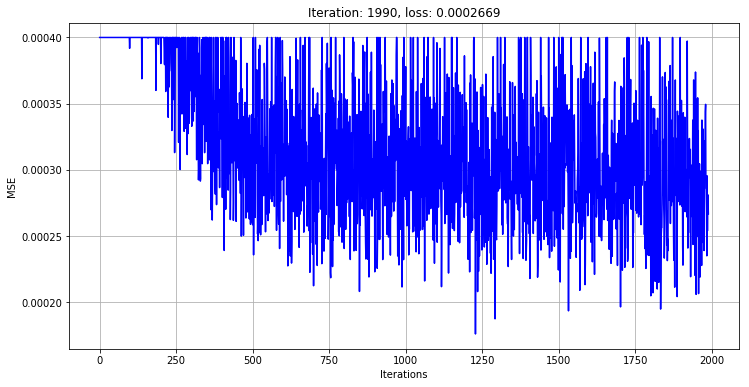

In [7]:
# train loop
denom = 2*(2**(1/2.)) # 2 * sqrt(2)
eps = 0.095
bound = ((-1/denom) + eps, (1/denom) - eps)
for cur_iter in range(num_iters):
    model.zerograds() # must always zero grads before another forward pass!
    
    # create mini-batches for training
    _x_in, _x_true = data_utils.next_minibatch([X_train, Y_train], mb_size, data_aug='rotate')
    #_x_in, _x_true = data_utils.normalize(_x_in), data_utils.normalize(_x_true)    
    x_in, x_true = chainer.Variable(_x_in), chainer.Variable(_x_true)
    
    # get prediction and loss
    x_hat = model(x_in, add=True) # prediction
    loss = nn.get_bounded_MSE(x_hat, x_true, boundary=bound) # bound = 0.095                
    #loss, loc_loss, vel_loss = nn.get_bounded_MSE_vel(x_hat, x_true, boundary=BOUND) # bound = 0.095
    
    # backprop and update
    loss.backward() # this calculates all the gradients (backprop)
    optimizer.update() # this updates the weights
    
    train_loss_history[cur_iter] = cuda.to_cpu(loss.data)
    if cur_iter % 10 == 0 and cur_iter != 0:
        y = train_loss_history[:cur_iter]
        plt.close('all')
        fig = data_utils.plot_training_curve(y, cur_iter, yclip=0.0004)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)

np.save(loss_path + save_label + 'train_loss', train_loss_history)
#print('{}: converged at {}'.format(model_save_label, np.median(lh_train[-150:])))
# save model, optimizer
data_utils.save_model([model, optimizer], model_dir + model_save_label)

In [13]:
bidx = nn.get_bounded(x_true[...,:3], 0.095)
bhat = F.get_item(x_hat[...,:3], bidx)
btrue = F.get_item(x_true[...,:3], bidx)
sqr_diff = F.squared_difference(bhat, btrue)
sum_sqr_diff = F.sum(sqr_diff, axis=-1)

In [9]:
xp.min(_x_true[...,:3])

array(2.0384789e-05, dtype=float32)

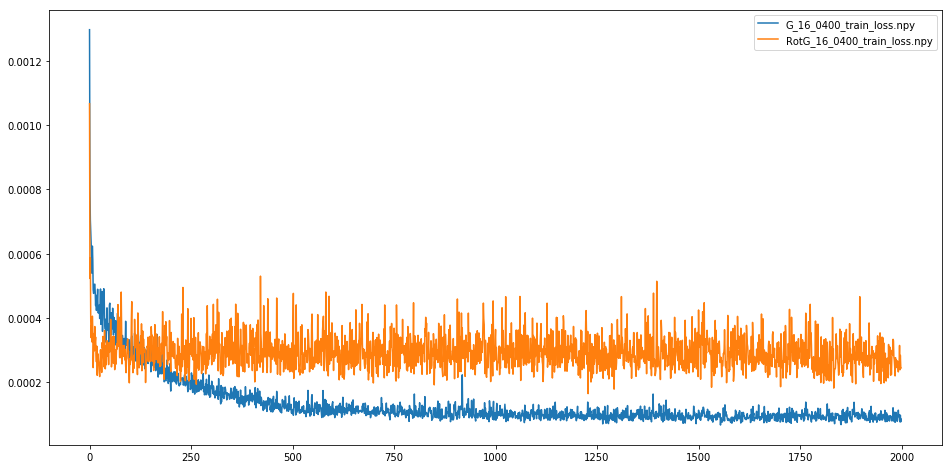

In [8]:
loss_labels = ['G_16_0400_train_loss.npy',
               'RotG_16_0400_train_loss.npy'
               'Rot2GL_16_0400_train_loss.npy']
lh_dict = {llabel:np.load(loss_path + llabel) for llabel in loss_labels}
plt.close('all')
plt.figure(figsize=(16,8))
pstart = 0
for label, loss in lh_dict.items():
    plt.plot(loss[pstart:], label=label)
plt.legend()
display.display(plt.gcf())
display.clear_output(wait=True)

In [14]:
from chainer.serializers import load_npz
model = models.GraphModel(channels)
model_save_label = 'G_16_0400_77743196_'
load_npz('{}{}.model'.format(model_dir, model_save_label), model)
if use_gpu: model.to_gpu()

In [15]:
# validation
validation_loss_history = np.zeros((num_val_batches))
with chainer.using_config('train', False):
    for val_iter in range(num_val_batches):
        j,k = val_iter * mb_size, (val_iter+1) * mb_size
        _val_in, _val_true = X_val[j:k], Y_val[j:k]
        val_in, val_true = chainer.Variable(_val_in), chainer.Variable(_val_true)
        
        val_hat  = model(val_in, add=True)
        val_loss = nn.mean_squared_error(val_hat, val_true)
        validation_loss_history[val_iter] = cuda.to_cpu(val_loss.data)
        print('{:<3}: {:.8}'.format(val_iter, validation_loss_history[val_iter]))
    np.save(loss_path + save_label + 'val_loss', validation_loss_history)
    print('{}: validation avg {}'.format(model_save_label, np.mean(validation_loss_history)))

0  : 9.3290488e-05
1  : 9.1763468e-05
2  : 8.4180276e-05
3  : 0.00013588619
4  : 8.1585691e-05
5  : 8.4469924e-05
6  : 8.4433683e-05
7  : 9.1588248e-05
8  : 6.9105059e-05
9  : 8.0118167e-05
10 : 8.2520099e-05
11 : 7.4855241e-05
12 : 0.00010116811
13 : 8.4584281e-05
14 : 0.00010005159
15 : 9.2386865e-05
16 : 9.5140014e-05
17 : 9.0737449e-05
18 : 0.00010576588
19 : 9.0127731e-05
20 : 8.2126113e-05
21 : 8.2276296e-05
22 : 9.8431243e-05
23 : 9.0143083e-05
24 : 8.8505287e-05
G_16_0400_77743196_: validation avg 9.020961908390746e-05


In [10]:
#rot2lh = validation_loss_history

In [13]:


0  : 0.00071449857
1  : 0.00083440135
2  : 0.00069077744
3  : 0.00076021155
4  : 0.00066414644
5  : 0.00076436519
6  : 0.00068148802
7  : 0.00077487406
8  : 0.00075997895
9  : 0.00072597218
10 : 0.00074742711
11 : 0.0006032426
12 : 0.0007503003
13 : 0.0007320182
14 : 0.00079973473
15 : 0.00073265145
16 : 0.00074171007
17 : 0.00076671556
18 : 0.00073367765
19 : 0.00074930477
20 : 0.00067527685
21 : 0.00074823305
22 : 0.00077885698
23 : 0.00079977652
24 : 0.0007059208
Rot2GL_16_0400_77743196_: validation avg 0.0007374224159866572
    
0  : 0.00055363186
1  : 0.0006731872
2  : 0.00058509264
3  : 0.0006904325
4  : 0.00056985248
5  : 0.00058646151
6  : 0.00057804317
7  : 0.00069477817
8  : 0.00058836123
9  : 0.00064376084
10 : 0.00058327831
11 : 0.00052094873
12 : 0.00069097709
13 : 0.00060718646
14 : 0.00060357916
15 : 0.00063511333
16 : 0.00061753101
17 : 0.00061934261
18 : 0.00070599839
19 : 0.00063490745
20 : 0.00057715503
21 : 0.00058344653
22 : 0.00068214984
23 : 0.00060094299
24 : 0.00063226151
Rot2GL_16_0400_77743196_: validation avg 0.0006183368014171719
    
0  : 9.3290488e-05
1  : 9.1763468e-05
2  : 8.4180276e-05
3  : 0.00013588619
4  : 8.1585691e-05
5  : 8.4469924e-05
6  : 8.4433683e-05
7  : 9.1588248e-05
8  : 6.9105059e-05
9  : 8.0118167e-05
10 : 8.2520099e-05
11 : 7.4855241e-05
12 : 0.00010116811
13 : 8.4584281e-05
14 : 0.00010005159
15 : 9.2386865e-05
16 : 9.5140014e-05
17 : 9.0737449e-05
18 : 0.00010576588
19 : 9.0127731e-05
20 : 8.2126113e-05
21 : 8.2276296e-05
22 : 9.8431243e-05
23 : 9.0143083e-05
24 : 8.8505287e-05
G_16_0400_77743196_: validation avg 9.020961908390746e-05

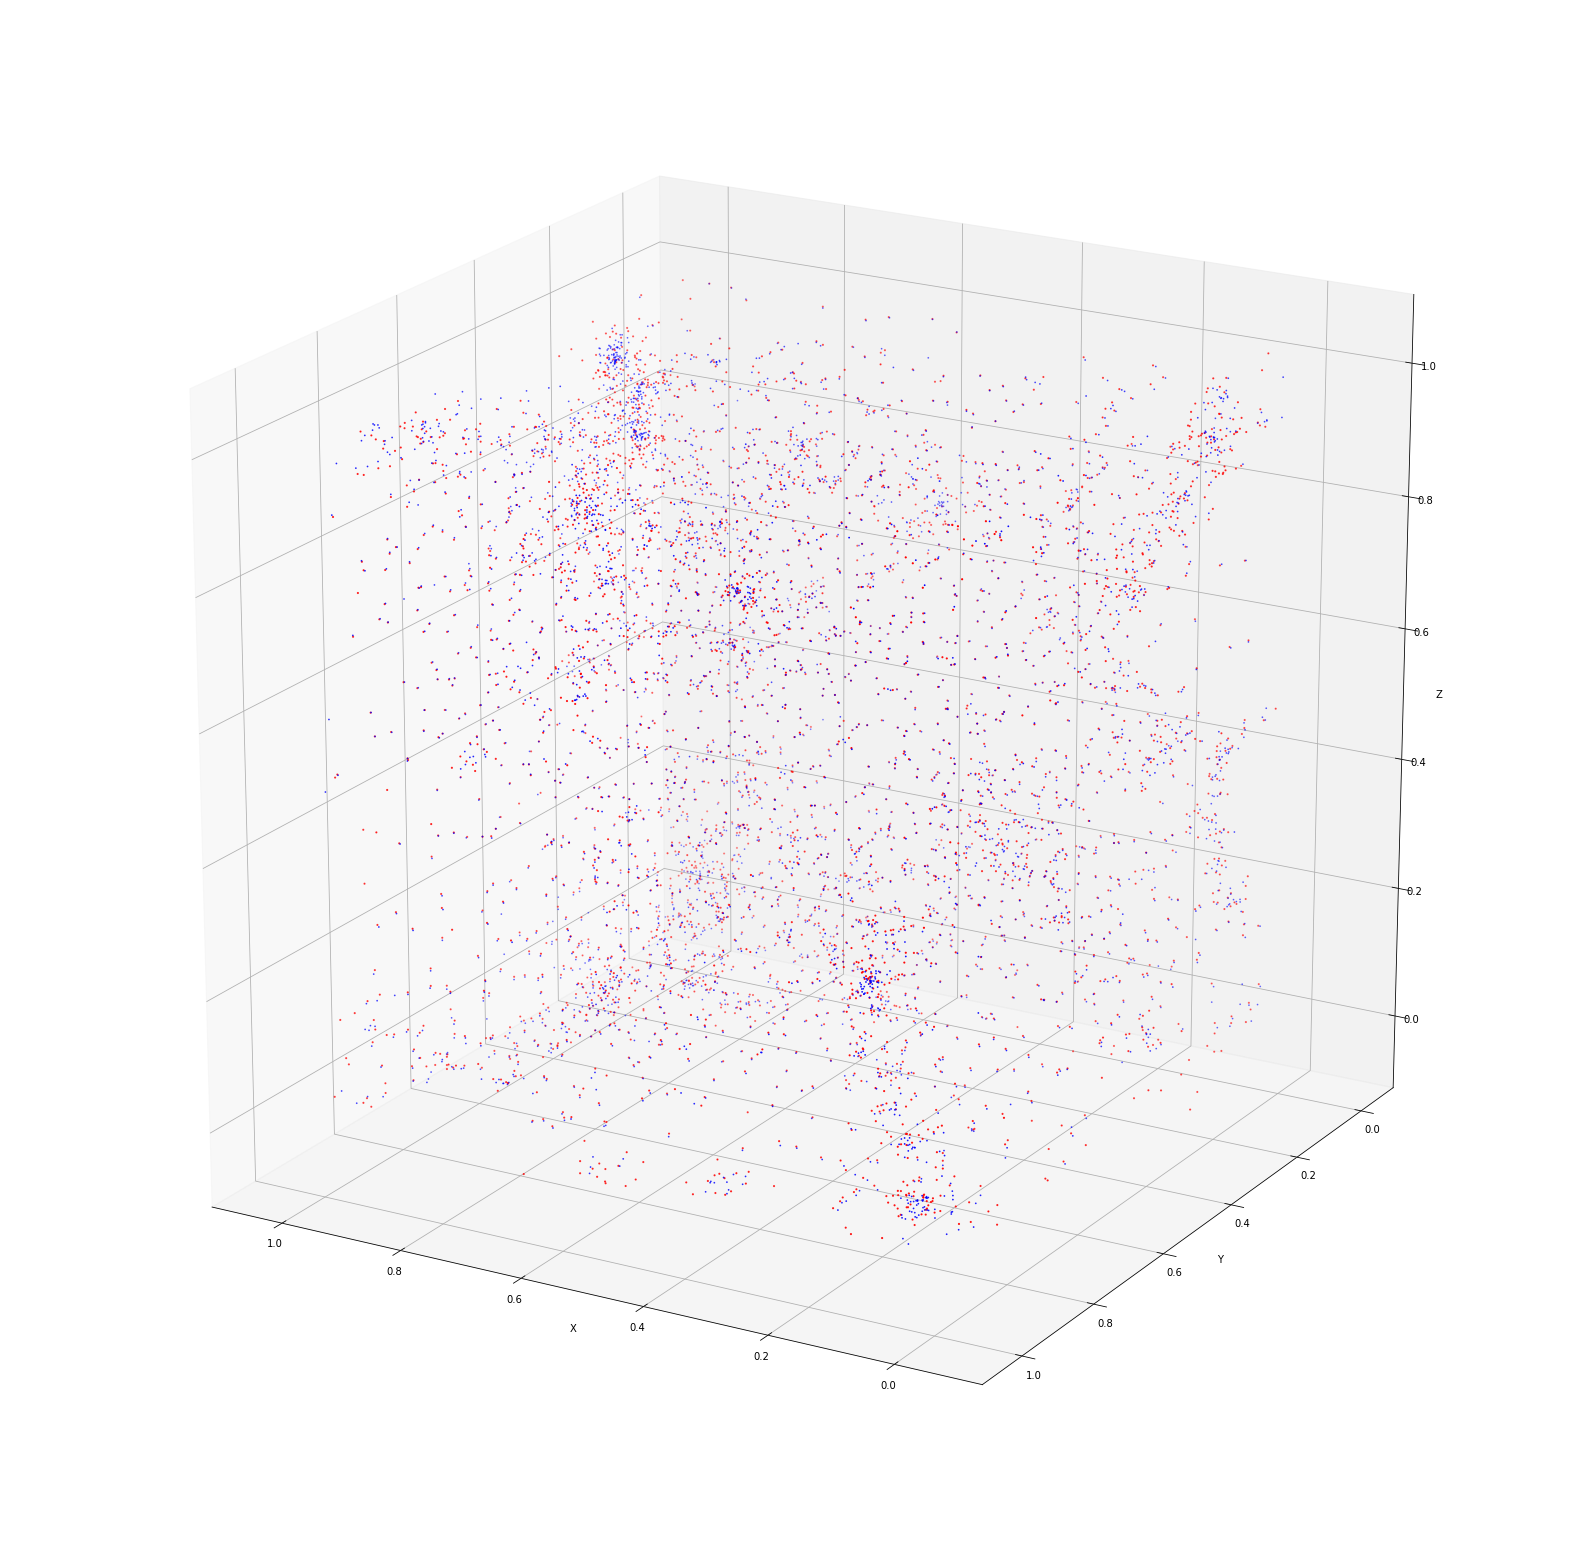

In [15]:
'''
plot point cloud
'''
from IPython import display
j = 3
fsize = (28,28)
particle_size = (.6, 1.3)
truth_color = 'blue'
pred_color = 'red'
colors = (truth_color, pred_color)

plt.close('all')
fig = data_utils.plot_3D_pointcloud(xt, xh, j, colors=colors, pt_size=particle_size, fsize=fsize)
plt.gca().view_init(20, 120)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)
rotate = False
if rotate:
    for angle in range(0,360,40):
        fig.view_init(30, angle)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
#fig.savefig('./Plots/' + model_name, dpi=2400,bbox_inches='tight') # warning, this makes a huge image